# Preprocessing of World Energy Consumption

# Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller 

As a first step, we'd like to build a simple model using GDP per capita, population size and energy consumption for a given country. In terms of causality, we would intuitively say that population and GDP have an influence on energy consumption. This first model is certainly very simple, but it will enable us to test our DBN implementation. Finally, we still need to define a scenario (I didn't quite understand this part). 

# Exploration

In [2]:
df = pd.read_csv("WorldEnergyConsumption.csv", sep=',')
df.head()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,ASEAN (Ember),2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,ASEAN (Ember),2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2,ASEAN (Ember),2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
3,ASEAN (Ember),2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
4,ASEAN (Ember),2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN


In [3]:
len(df['year'].drop_duplicates().values)

123

There are 123 years, but a closer look reveals that some of them are far too distant to be of interest.
First of all, we can see that the quality of the data is poor, with a lot of NaN. What strategy should we adopt? 

* Remove the NaN &rarr; problem: we'll end up with very little data if we apply dropna
* Try interpolation &rarr; depends on the number of NaN per column

We can first have a look to the number of NaN in each category:

In [4]:
df.isna().sum()

country                       0
year                          0
iso_code                   5500
population                 3889
gdp                       10899
                          ...  
wind_elec_per_capita      14947
wind_electricity          14016
wind_energy_per_capita    17947
wind_share_elec           15126
wind_share_energy         17911
Length: 129, dtype: int64

In [5]:
df = df.loc[df['year'] > 1970]

Une autre idée serait de regarder le nombre de NaN partitionné en fonction des pays. Ainsi on pourra mettre de côté les pays ayant trop de données manquantes.

In [6]:
nan_count = df.groupby('country').apply(lambda x: x.isna().sum())

In [7]:
test = nan_count.loc[nan_count['gdp'] < 10]
test = test.loc[test['population'] < 10]
test = test.loc[test['energy_per_capita'] < 10]
test[['gdp', 'population', 'energy_per_capita']]

,gdp,population,energy_per_capita
country,,,
Afghanistan,3,0,9
Albania,3,0,9
Algeria,4,0,0
Argentina,4,0,0
Armenia,3,0,0
...,...,...,...
Venezuela,4,0,0
Vietnam,4,0,0
Yemen,4,0,1


There are 151 countries with less than 10 NaN for gdp, population and per capita consumption.

In [45]:
df_usa = df[df['country']=='United States'][['year', 'gdp', 'population', 'energy_per_capita']]

In [46]:
df_usa

,year,gdp,population,energy_per_capita
20659,1971,5.065682e+12,202907920.0,91613.023
20660,1972,5.334297e+12,205238384.0,95080.078
20661,1973,5.637203e+12,207314768.0,98110.688
20662,1974,5.621366e+12,209277968.0,94814.602
20663,1975,5.605795e+12,211274544.0,91442.539
20664,1976,5.899591e+12,213270032.0,95543.227
20665,1977,6.166912e+12,215437408.0,96991.727
20666,1978,6.518624e+12,217881440.0,98031.711
20667,1979,6.740172e+12,220463104.0,97904.820
20668,1980,6.743208e+12,223140016.0,92999.711


Text(0.5, 1.0, 'Energy per Capita')

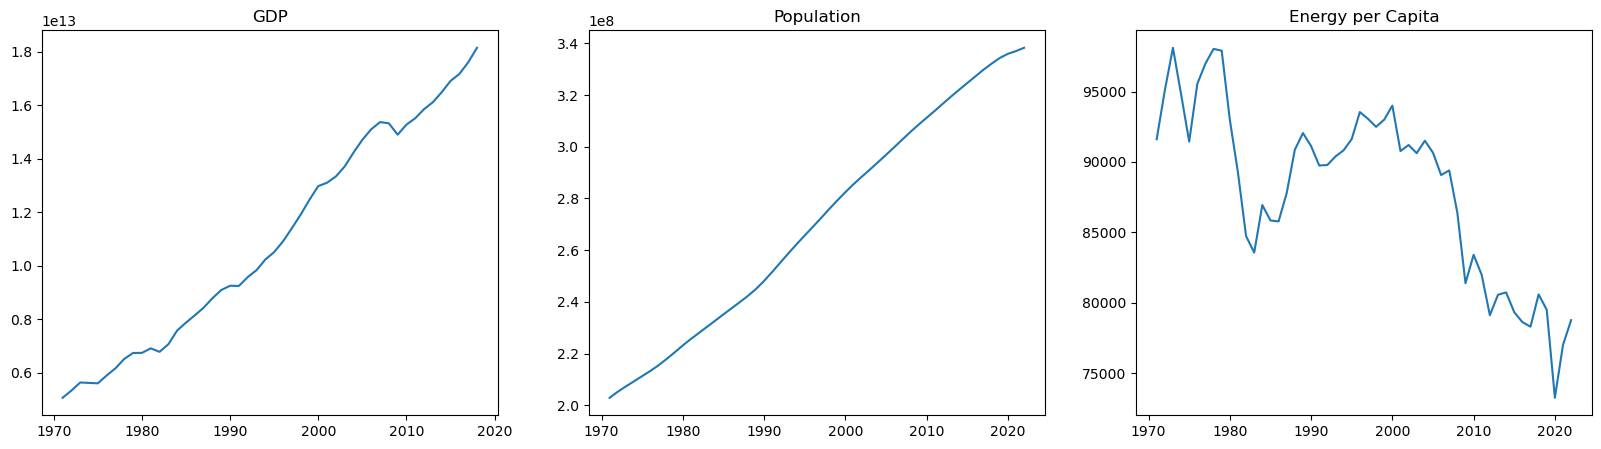

In [56]:
figs, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].plot(df_usa['year'], df_usa['gdp'])
axs[0].set_title('GDP')
axs[1].plot(df_usa['year'], df_usa['population'])
axs[1].set_title('Population')
axs[2].plot(df_usa['year'], df_usa['energy_per_capita'])
axs[2].set_title('Energy per Capita')


In [96]:
df_usa['gdp stationary'] = df_usa['gdp'] - df_usa['gdp'].shift()
df_usa['population_order_1'] = df_usa['population'] - df_usa['population'].shift()
df_usa['energy_per_capita_stationary'] = df_usa['energy_per_capita'] - df_usa['energy_per_capita'].shift()
df_usa['population_order_2'] = df_usa['population_order_1'] - df_usa['population_order_1'].shift()
df_usa['population_stationary'] = df_usa['population_order_2'] - df_usa['population_order_2'].shift()

In [97]:
df_usa

,year,gdp,population,energy_per_capita,gdp stationary,population stationary,energy_per_capita_stationary,population_order_1,population_stationary,population_order_2,population_order_3
20659,1971,5.065682e+12,202907920.0,91613.023,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20660,1972,5.334297e+12,205238384.0,95080.078,2.686148e+11,2330464.0,3467.055,2330464.0,NaN,NaN,NaN
20661,1973,5.637203e+12,207314768.0,98110.688,3.029063e+11,2076384.0,3030.610,2076384.0,NaN,-254080.0,NaN
20662,1974,5.621366e+12,209277968.0,94814.602,-1.583717e+10,1963200.0,-3296.086,1963200.0,140896.0,-113184.0,140896.0
20663,1975,5.605795e+12,211274544.0,91442.539,-1.557083e+10,1996576.0,-3372.063,1996576.0,146560.0,33376.0,146560.0
20664,1976,5.899591e+12,213270032.0,95543.227,2.937958e+11,1995488.0,4100.688,1995488.0,-34464.0,-1088.0,-34464.0
20665,1977,6.166912e+12,215437408.0,96991.727,2.673213e+11,2167376.0,1448.500,2167376.0,172976.0,171888.0,172976.0
20666,1978,6.518624e+12,217881440.0,98031.711,3.517118e+11,2444032.0,1039.984,2444032.0,104768.0,276656.0,104768.0
20667,1979,6.740172e+12,220463104.0,97904.820,2.215479e+11,2581664.0,-126.891,2581664.0,-139024.0,137632.0,-139024.0
20668,1980,6.743208e+12,223140016.0,92999.711,3.036152e+09,2676912.0,-4905.109,2676912.0,-42384.0,95248.0,-42384.0


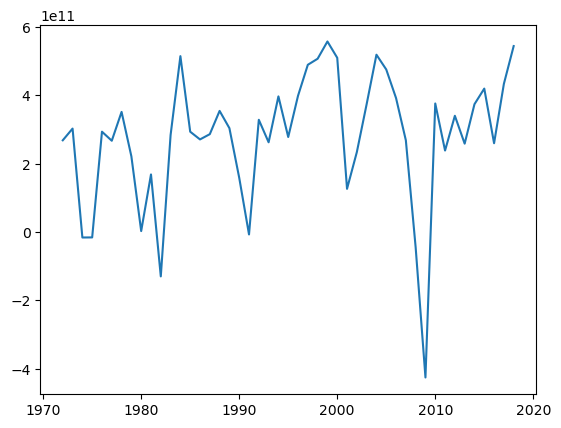

In [98]:
plt.plot(df_usa['year'], df_usa['gdp stationary'])

Text(0.5, 1.0, 'Energy per Capita')

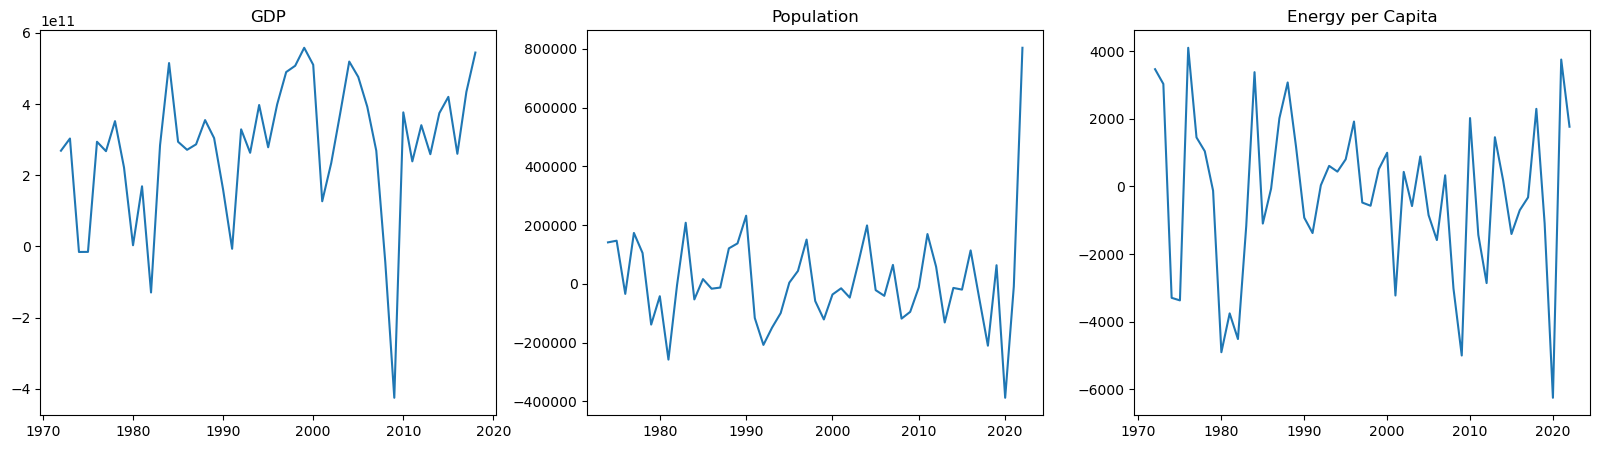

In [99]:
figs, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].plot(df_usa['year'], df_usa['gdp stationary'])
axs[0].set_title('GDP')
axs[1].plot(df_usa['year'], df_usa['population_stationary'])
axs[1].set_title('Population')
axs[2].plot(df_usa['year'], df_usa['energy_per_capita_stationary'])
axs[2].set_title('Energy per Capita')

In the case of the United States, we're missing data for the last few years... So we won't be looking at the last few years when we apply the model.

How to transform our signal into a stationary signal:

- if a trend or seasonality appears, we can try to subtract the seasonality and trend components.

In the case of population and GDP, we can clearly see a trend (and not especially seasonality). We can try to estimate this trend (which looks linear). 
To check stationarity, we can perform the Augmented Dickey Fuller test. This test has the following hypothesis:

H0: the time series has a unit root (i.e. a trend component)

In [101]:
adfuller(df_usa['gdp stationary'][1:-4])

(-4.309650751687184,
 0.0004274256915090369,
 0,
 46,
 {'1%': -3.5812576580093696,
  '5%': -2.9267849124681518,
  '10%': -2.6015409829867675},
 1970.066673557125)

In [105]:
adfuller(df_usa['population_stationary'][3:])

(-3.5071505242663634,
 0.007805341279116967,
 7,
 41,
 {'1%': -3.60098336718852,
  '5%': -2.9351348158036012,
  '10%': -2.6059629803688282},
 987.9357999939783)

In [ ]:
adfuller(df_usa['energy_per_capita_stationary'][1:])

(-3.7739454210300973,
 0.00318542382737276,
 2,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 706.282325382784)

A signal is stationary if the null hypothesis can be rejected. To do this, we need to look at the p-value (second output of the stasmodel function). If this value is smaller than 0.05, then we can reject the null hypothesis and consider our signal to be stationary. If not, we need to find a way to make it stationary. 

In our case, we've managed to make our signals trend stationary.

Teaching:

- detrending is done on a case-by-case basis 
- first, visualize the data. This visualization gives an initial idea of a signal's stationarity.
- The non-stationarity or stationarity of a signal must then be confirmed with the Augmented Duckey Fuller test (the link at the end of the document also mentions another type of test).

Next step:

- Will it be possible to obtain a general function for pipelining? I don't think so.
- We've shown that there's no trend, but what about seasonality? When we look at the plots, there doesn't seem to be any (on a yearly scale, but if we take another dataset).
- Test the model developed by Mehdi on a GDP, population and per capita energy consumption scenario


Source:

- https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html